In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torch.utils.data.dataset import random_split
from tqdm import tqdm
import math
from torch.optim import lr_scheduler
'''
ATTENTION!
 Upload training data and prediction template before Starting
'''

'\n Upload training data and prediction template before Starting\n'

# Define Model and Dataset Classes

In [ ]:
class Attention(nn.Module):
  def __init__(self, enc_hidden_dim, dec_hidden_dim):
    super().__init__()
    self.dec_hidden_dim = dec_hidden_dim
    self.enc_hidden_dim = enc_hidden_dim
    

    self.fc1 = nn.Linear(self.enc_hidden_dim+self.dec_hidden_dim, self.dec_hidden_dim)
    self.mat = nn.Parameter(torch.rand(self.dec_hidden_dim))

  def forward(self, enc_hidden, decoder_hidden):
    #enc_hidden --> hidden states of all inputs into enc --> (batch_size, seq_len, enc_hidden_dim)
    #decoder_hidden --> output of last decoder state --> (batch_size,1, dec_hidden_dim)
    #output --> attention weights --> (batch_size, seq_len)
    #print(enc_hidden.size())
    #print(decoder_hidden.size())
    batch_size = enc_hidden.size(0)
    seq_len = enc_hidden.size(1)

    decoder_hidden = decoder_hidden.repeat(1,seq_len,1)
    #print(decoder_hidden.size())
    #print(enc_hidden.size())

    out = torch.tanh(self.fc1(torch.cat([decoder_hidden, enc_hidden], axis = 2))) #(batch_size, seq_len, dec_hidden_size)
    mat = self.mat.repeat(batch_size,1).unsqueeze(2) #(batch_size, dec_hidden_dim,1)
    weights = torch.softmax(torch.bmm(out, mat), dim = 1)
    #print(weights.size())

    return weights


In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_dim, embed_dim, hidden_dim, n_layers = 1, dropout = 0.5, bidirectional = False):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.embed_dim = embed_dim
    self.bidirectional = bidirectional
    self.n_layers = n_layers

    self.embed = nn.Linear(self.input_dim, self.embed_dim)
    self.gru = nn.GRU(self.embed_dim, self.hidden_dim, dropout = dropout, bidirectional = self.bidirectional, batch_first=True, num_layers = n_layers)

  def forward(self, input, hidden = None):
    embedded = self.embed(input)
    output, hidden = self.gru(embedded, hidden)

    if self.bidirectional:
      output = (output[:,:,:self.hidden_dim] + output[:,:,self.hidden_dim:])
    
    return output, hidden



In [ ]:
class Encoder_transformer(nn.Module):
  def __init__(self, input_dim, embed_dim, hidden_dim, n_layers = 1, dropout = 0.5, n_head = 8):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.embed_dim = embed_dim
    self.n_layers = n_layers

    self.embed = nn.Linear(self.input_dim, self.embed_dim)
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=n_head, dim_feedforward = self.hidden_dim, dropout = dropout, batch_first=True)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
    self.pe = PositionalEncoder(self.embed_dim)
  
  def forward(self, input, t): # t np array is of shape [batch_size, num_timesteps]):
    embedded = self.embed(input)
    embedded = self.pe(embedded, t)
    output = self.transformer_encoder(embedded)
    return output, None

In [ ]:
class Decoder(nn.Module):
  def __init__(self, embed_dim, hidden_dim, output_dim, enc_out_dim, n_layers = 1, dropout = 0.2):
    super().__init__()
    self.embed_dim = embed_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.enc_out_dim = enc_out_dim
    self.n_layers = n_layers
    #assert self.embed_dim == self.output_dim

    self.dropout = nn.Dropout(dropout)
    self.embed = nn.Linear(self.output_dim, self.embed_dim)
    self.out = nn.Linear(self.hidden_dim, self.output_dim)
    self.gru = nn.GRU(self.embed_dim+self.enc_out_dim, self.hidden_dim, n_layers, dropout=dropout, batch_first=True)
    self.attention = Attention(self.enc_out_dim, self.hidden_dim)

  def forward(self, enc_outputs, prev_hidden, input):
    
    inp = self.embed(input)
    inp = self.dropout(inp).unsqueeze(1)

    attn_weights = self.attention(enc_outputs, prev_hidden[-1,:,:].unsqueeze(1))
    context = torch.bmm(attn_weights.transpose(1,2), enc_outputs)
    
    inp = torch.cat([context, inp], axis = 2)
    output, hidden = self.gru(inp, prev_hidden)

    output = output.squeeze(1)
    output = torch.abs(self.out(output))

    return output, hidden



In [ ]:
class RNNModel(nn.Module):
  def __init__(self, encoder, decoder, val = False, tf_ratio = 0):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.val = val
    self.tf_ratio = tf_ratio

    #assert self.encoder.n_layers >= self.decoder.n_layers

  def forward(self, src, pred_len, target, src_t):
    outputs = []
    #print(src[:,-1,:].size())
    if not self.val:
      target = torch.cat([src[:,-1,:].unsqueeze(1), target], axis = 1)

    enc_outputs, hidden = self.encoder(src, src_t)
    if hidden is None:
      hidden = torch.zeros((self.decoder.n_layers, src.size(0), self.decoder.hidden_dim)).to(src.device)
    else:
      hidden = hidden[:self.decoder.n_layers,:,:]
    
    output = src[:,-1,:]
    for i in range(pred_len):
      if random.random() >= self.tf_ratio or self.val:
        input = output
      else:
        input = target[:,i,:]
      output, hidden = self.decoder(enc_outputs, hidden, input)
      outputs+=[output]
    if len(outputs) == 1:
      outputs = outputs[0].unsqueeze(1)
    else:
      outputs = torch.stack(outputs, axis = 1)
    return outputs

In [ ]:
class PositionalEncoder():
  def __init__(self, d_model, max_len = 500):
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    self.sqrt_d = math.sqrt(d_model)
    self.pe = torch.zeros(max_len, 1, d_model)
    self.pe[:, 0, 0::2] = torch.sin(position * div_term)
    self.pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.pe = self.pe.squeeze(1)
  
  def __call__(self, x, t): # x is tensor [batch_size, seq_len, d_model], t is array [batch_size, seq_len]
    p_encs = []
    for t_batch in t:
      p_encs += [self.pe[t_batch, :]]
    p_enc = torch.stack(p_encs, dim = 0).to(x.device)
    x = x*self.sqrt_d + p_enc
    return x


In [ ]:
class volatility(Dataset):
    def __init__(self, window_len_x=7, window_len_y=1, train = True, split_ratio = 0.7, win=1) -> None:
        super(volatility).__init__()
        self.window_len_x = window_len_x
        self.window_len_y = window_len_y
        self.train = train
        self.split_ratio = split_ratio
        self.win = win
        self._load_dataset()
        

    def _load_dataset(self):
        data = pd.read_csv('training_data.csv')

        data["Date"] = pd.to_datetime(data["Date"])
        grouped = data.groupby('Date')
        self.dates = []
        self.vecs = []
        for g in grouped.groups:
            grp = grouped.get_group(g)
            mat = np.array(grp.iloc[:, 2:21])
            vec = mat.reshape(-1,)
            self.dates.append(g)
            self.vecs.append(vec)
      
        self.dates = pd.DataFrame(self.dates, columns=['Date'])
        self.dates["Date"] = pd.to_datetime(self.dates["Date"])
        
        # self.vecs = list(self.np_vecs_avg)
        # print("Vecs:", self.np_vecs_avg[:100,0])
        if self.train:
          
          self.dates = self.dates[:int(self.split_ratio*len(self.dates))]
          self.vecs = self.vecs[:int(self.split_ratio*len(self.vecs))]
        else:
          self.dates = self.dates[int(self.split_ratio*len(self.dates)):]
          self.vecs = self.vecs[int(self.split_ratio*len(self.vecs)):]

    def __getitem__(self, index):
        lstx = self.dates[index:index+self.window_len_x].copy()
        lsty = self.dates[index+self.window_len_x-1:index+self.window_len_x+self.window_len_y-1].copy()

        X = self.vecs[index:index+self.window_len_x].copy()
        y = self.vecs[index+self.window_len_x:index+self.window_len_x+self.window_len_y].copy()

        lstx = lstx.reset_index(drop=True)
        lsty = lsty.reset_index(drop=True)
        lstx = (lstx - lstx.iloc[0])['Date'].dt.days.to_numpy()
        # lstx_numpy = lstx.to_numpy()
        # diffx = (lstx_numpy[:] - lstx_numpy[0])/86400000000000
        # diffx = np.array(diffx, dtype = 'int').reshape(-1)
        # lstx = diffx
        # print("diffx:", diffx)
        
        # lstx = (lstx.iloc[:]['Date'] - lstx.iloc[0]['Date']).dt.days.to_numpy()
        # lstx = np.array(list(range(len(lstx))))
        lsty = (lsty - lsty.iloc[0])['Date'].dt.days.to_numpy()
        # lsty = np.array(list(range(len(lsty))))

        X = np.array(X)
        y = np.array(y)

        return torch.Tensor(X), torch.Tensor(y), lstx, lsty

    def __len__(self):
      return len(self.dates) - self.window_len_x -self.window_len_y + 1


# Define Loss function

In [ ]:
mseloss = nn.MSELoss()

def temporal_continuity(src, pred):
  l = pred.size(1)
  mat = torch.cat([src[:,-1,:].unsqueeze(1), pred], axis = 1)
  loss = 0
  for i in range(l-1):
    diff = torch.mean(torch.abs(mat[:,i,:] - mat[:,i-1,:]))
    loss+=diff
  return loss

def spatial_continuity(pred):
  loss = 0
  l = pred.size(1)
  batch_size = pred.size(0)
  for i in range(l):
    mat = pred[:,i,:].view(batch_size, 19, 19)
    del_x= torch.gradient(mat, dim = 1)[0]
    del_y= torch.gradient(mat, dim = 2)[0]
    grad_mag = torch.sqrt(del_x.pow(2) + del_y.pow(2))
    loss+=torch.mean(grad_mag)

  return loss

def calc_loss(src, target, pred):
  rmse_loss = mseloss(target, pred)
  temp_loss = temporal_continuity(src, pred)
  spatial_loss = spatial_continuity(pred)

  loss = rmse_loss + (temp_loss + 5*spatial_loss)*1e-3
  return loss, rmse_loss

# Create Dataloaders, define hyper-params, initialise model and optimizer

In [ ]:
window_len_x = 50
window_len_y = 10
avg_win = 1
trainset = volatility(window_len_x = window_len_x, window_len_y = window_len_y, train = True, win=avg_win)
valset = volatility(window_len_x = window_len_x, window_len_y = window_len_y, train = False, win=avg_win)

In [ ]:
train_dataloader = DataLoader(trainset, batch_size = 64, shuffle = True, pin_memory = True, num_workers = 4)
test_dataloader = DataLoader(valset, batch_size = 2, shuffle = False, pin_memory = True, num_workers = 4, drop_last = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
input_dim = 361
output_dim = 361
enc_hidden_dim = 512
dec_hidden_dim = 512
embed_dim = 512
n_layers_enc = 3
n_layers_dec = 3
tf_ratio = 0.1
n_head = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

encoder = Encoder_transformer(input_dim, embed_dim, enc_hidden_dim, n_layers_enc, n_head = n_head)
decoder = Decoder(embed_dim, dec_hidden_dim, output_dim, enc_hidden_dim, n_layers_dec)
model = RNNModel(encoder, decoder, tf_ratio = tf_ratio).to(device)

# optim = torch.optim.Adam(model.parameters(), lr = 4e-5, weight_decay = 1e-5)
optim = torch.optim.Adam(model.parameters(), lr = 4e-5, weight_decay = 1e-5, betas=(0.95,0.999))
scheduler = lr_scheduler.ExponentialLR(optim, gamma=0.99, verbose = True)



Adjusting learning rate of group 0 to 4.0000e-05.


# Train and Eval on split up datasets

In [ ]:
epochs = 1000
train_history = []
val_history = []
min_loss = 100
counter = 0
patience = 10


for e in range(epochs):
  model.train()
  model.val = False
  loss_history_temp = []
  for i, (src, trg, src_t, trg_t) in enumerate(train_dataloader):
    src, trg = src.to(device), trg.to(device)
    src_t, trg_t = np.array(src_t), np.array(trg_t)
    pred = model(src, window_len_y, trg, src_t)
    
    loss, _ = calc_loss(src, trg, pred)

    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_history_temp+=[loss.item()]

  model.eval()
  model.val = True
  loss_history_val_temp = []
  for i, (src, trg, src_t, trg_t) in enumerate(test_dataloader):
    src, trg = src.to(device), trg.to(device)
    src_t, trg_t = np.array(src_t), np.array(trg_t)
    pred = model(src, window_len_y, trg, src_t)
    _, loss = calc_loss(src, trg, pred)

    loss_history_val_temp+=[loss.item()]

  avg_val = sum(loss_history_val_temp)/len(loss_history_val_temp)
  avg_train = sum(loss_history_temp)/len(loss_history_temp)

  if avg_val < min_loss:
    counter = 0
    best_model = model
    min_loss = avg_val
  else:
    counter+=1

  if counter == patience:
    break

  print(f'Epoch {e+1} Loss {avg_train} Val Loss{avg_val}')
  val_history+=[avg_val]
  train_history+=[avg_train]
  scheduler.step()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Loss 0.0012655443570110947 Val Loss0.0006625636194187861
Adjusting learning rate of group 0 to 1.4495e-05.
Epoch 2 Loss 0.00127040411462076 Val Loss0.0006798762096411501
Adjusting learning rate of group 0 to 1.4350e-05.
Epoch 3 Loss 0.0012576427252497524 Val Loss0.0006788551086524072
Adjusting learning rate of group 0 to 1.4206e-05.
Epoch 4 Loss 0.0012667796981986612 Val Loss0.0006679168785549103
Adjusting learning rate of group 0 to 1.4064e-05.
Epoch 5 Loss 0.0012574915017466992 Val Loss0.0006343635740892914
Adjusting learning rate of group 0 to 1.3924e-05.
Epoch 6 Loss 0.0012607079988811165 Val Loss0.0006341525030364163
Adjusting learning rate of group 0 to 1.3784e-05.
Epoch 7 Loss 0.0012531918764580041 Val Loss0.0006404151848609893
Adjusting learning rate of group 0 to 1.3647e-05.
Epoch 8 Loss 0.00125964343897067 Val Loss0.0006569223734027802
Adjusting learning rate of group 0 to 1.3510e-05.
Epoch 9 Loss 0.0012378954561427236 Val Loss0.0006497060092395912
Adjusting learning 

In [ ]:
val_preds = []
model.eval()
model.val = True
test_dataloader = DataLoader(valset, batch_size = 1, shuffle = False, pin_memory = True, num_workers = 4, drop_last = True)
first = True
with torch.no_grad():
  for i, (src, trg, src_t, trg_t) in enumerate(test_dataloader):
      src, trg = src.to(device), trg.to(device)
      src_t, trg_t = np.array(src_t), np.array(trg_t)
      pred = model(src, window_len_y, trg, src_t)
      if first:
        val_preds+=[pred]
        first = False
      else:
        val_preds+=[pred[:,-1,:].unsqueeze(1)]
val_preds = torch.cat(val_preds, dim=1).squeeze(0).view(-1,19,19).cpu().numpy()
val_actuals = np.array(valset.vecs)[-58:,:].reshape(-1,19,19)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import matplotlib.pyplot as plt
plt.plot(val_history, color = 'r', label = 'Validation Loss')
plt.plot(train_history, color = 'g', label = 'Train Loss')
plt.title('Val and Train Loss')
plt.legend()
# plt.ylim([0,0.01])

# Entire dataset

In [ ]:
fullset = volatility(window_len_x = window_len_x, window_len_y = window_len_y, train = True, split_ratio = 1)
full_dataloader = DataLoader(fullset, batch_size = 32, shuffle = False, pin_memory = True, num_workers = 4)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Make Prediction

In [ ]:
template = pd.read_csv('prediction_template.csv')
template['Date'] = pd.to_datetime(template['Date'])
unique_dates = sorted(template['Date'].unique())

roll_dates = fullset.dates[-window_len_x:].to_numpy().reshape(-1)
# print(roll_dates)
X,y, X_t, y_t = fullset[len(fullset)-1]
inp = torch.cat([X,y], dim = 0)
inp = inp[-1-window_len_x:-1,:].unsqueeze(0).to(device)

days_to_pred = 60
slides = int(days_to_pred/window_len_y)
extra = days_to_pred%window_len_y

best_model.eval()
best_model.val = True
with torch.no_grad():
  preds = []
  for i in range(slides):
    pred = best_model(inp, window_len_y, target = None, src_t = X_t)
    preds+=[pred]
    inp = torch.cat([inp, pred], dim = 1)[:,-1-window_len_x:-1,:]
    roll_dates = np.concatenate([roll_dates, unique_dates[i*window_len_y:(i+1)*window_len_y]])
    roll_dates = roll_dates[-window_len_x:]
    # print("Another one:", roll_dates[-window_len_y:])
    X_t = (roll_dates[:] - roll_dates[0])/86400000000000
    X_t = np.array(X_t, dtype = 'int').reshape(-1)
    # print("X_t last window_len_y values:", X_t[-window_len_y:])
    # break
  
  if extra != 0:
    pred = best_model(inp, extra, target = None, src_t = X_t)
    preds+=[pred]

  prediction = torch.cat(preds, dim=1). squeeze(0)


prediction = prediction.view(days_to_pred, 19, 19)
prediction_for_plots = prediction.view(days_to_pred, 19, 19).cpu().numpy()
prediction = torch.split(prediction, split_size_or_sections = 1, dim=0)
prediction = torch.cat(prediction, dim=1).squeeze(0).cpu().numpy()

columns = template.columns
final = np.concatenate((np.array(template['Date']).reshape(-1,1), np.array(template['Tenor']).reshape(-1,1), prediction), axis = 1)
final = pd.DataFrame(final, columns = columns)
final.to_csv('prediction.csv', index = False)



In [ ]:
fullset_reshaped = np.array(fullset.vecs)[:,:].reshape(-1,19,19)
fullset_reshaped.shape

(718, 19, 19)

# Prediction Visualisation

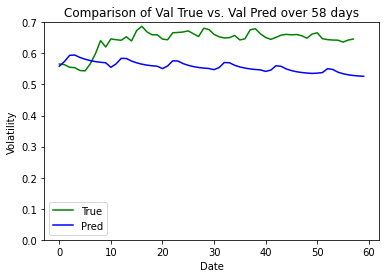

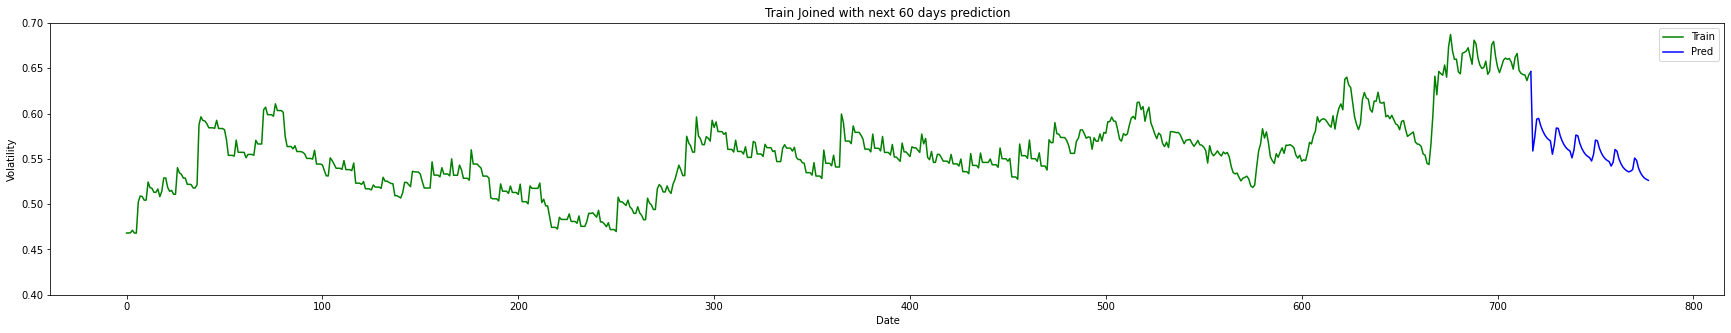

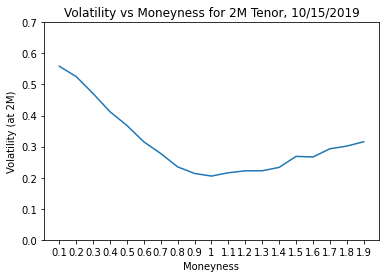

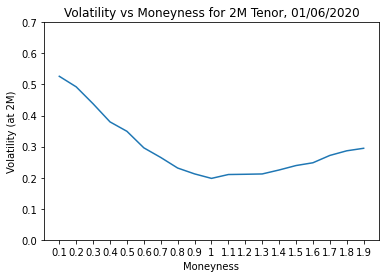

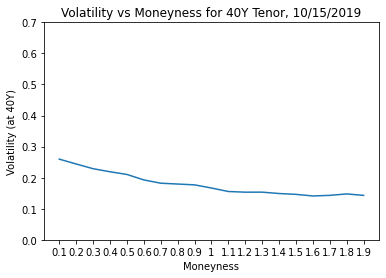

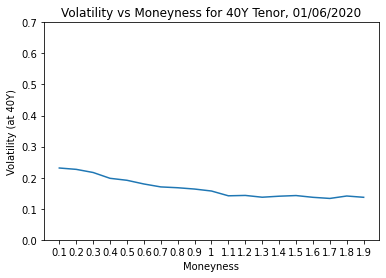

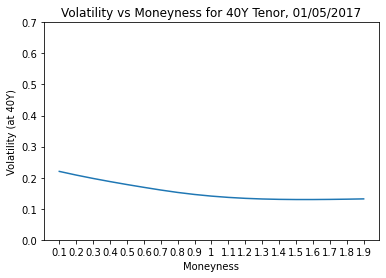

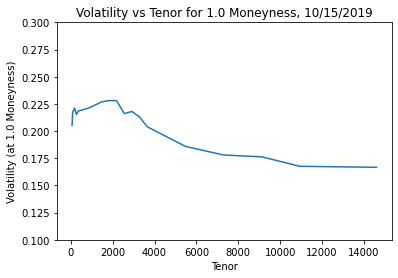

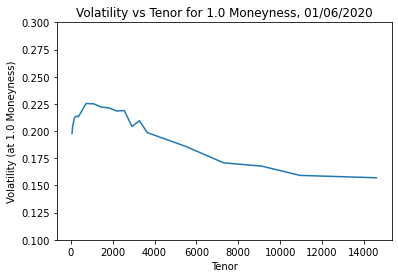

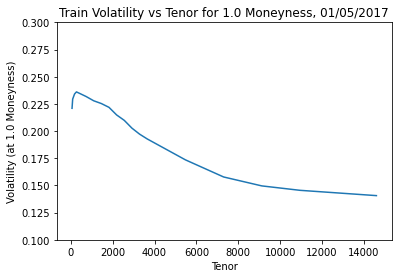

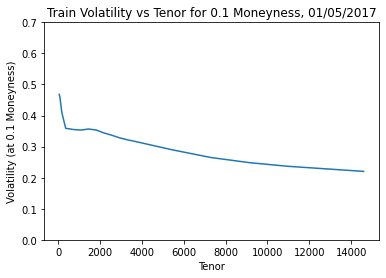

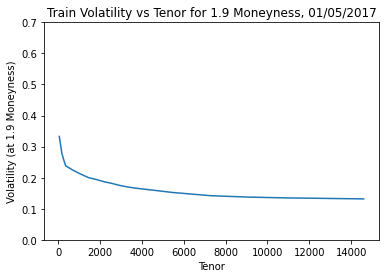

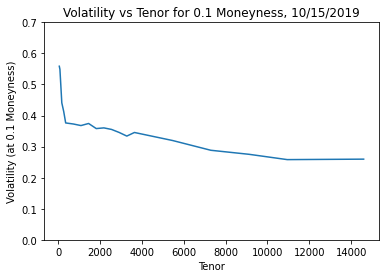

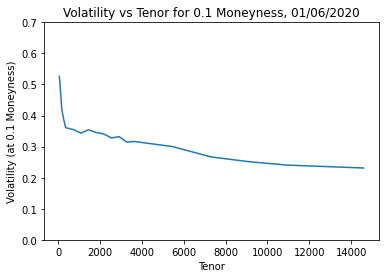

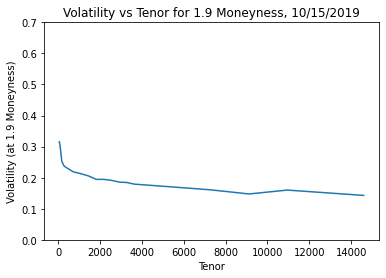

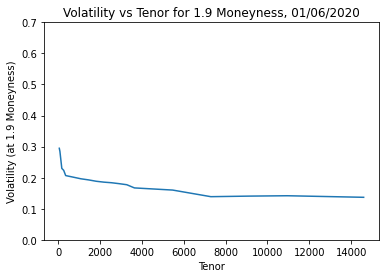

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv("training_data.csv")
pred_df = pd.read_csv("prediction.csv")
#print(pred_df.head())

val_preds = pred_df.iloc[:, 2:].to_numpy().reshape([-1,19,19])
tenor_vals = [30*v for v in [2,3,6,9]] + [365*v for v in [1,2,3,4,5,6,7,8,9,10,15,20,25,30,40]]

# mnns = pred_df.columns[2:]
# mnns = [float(c) for c in mnns]
vol_2m_10_15 = pred_df.iloc[0, 2:]
vol_2m_01_06 = pred_df.iloc[1121, 2:]
vol_40y_10_15 = pred_df.iloc[18, 2:]
vol_40y_01_06 = pred_df.iloc[1139, 2:]
vol_train_40y_01_05 = train_df.iloc[18, 2:]

vol_10_mnns_10_15 = pred_df.iloc[0:19, 11]
vol_10_mnns_01_06 = pred_df.iloc[1121:1140, 11]
vol_19_mnns_10_15 = pred_df.iloc[0:19, 20]
vol_19_mnns_01_06 = pred_df.iloc[1121:1140, 20]
vol_01_mnns_10_15 = pred_df.iloc[0:19, 2]
vol_01_mnns_01_06 = pred_df.iloc[1121:1140, 2]
vol_train_19_mnns_01_05 = train_df.iloc[0:19, 20]
vol_train_01_mnns_01_05 = train_df.iloc[0:19, 2]
vol_train_10_mnns_01_05 = train_df.iloc[0:19, 11]

val_mnns_ind = 0
val_tenor_ind = 0
vol_val_pred =     val_preds[:, val_mnns_ind, val_tenor_ind]

tot_mnns_ind = 0
tot_tenor_ind = 0
train_tail = fullset_reshaped.shape[0]

# Join train with prediction of next 60 days, check for jumps

plt.figure(figsize=(30,5))
plt.plot([i for i in range(train_tail)], fullset_reshaped[-train_tail:, tot_mnns_ind, tot_tenor_ind], 'g')
plt.plot([i for i in range(train_tail-1, train_tail+60)], np.hstack((fullset_reshaped[-1, tot_mnns_ind, tot_tenor_ind], val_preds[:, tot_mnns_ind, tot_tenor_ind])), 'b')
plt.title("Train Joined with next 60 days prediction")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.ylim([0.4,0.7])
plt.legend(["Train", "Pred"])

# Volatility vs Moneyness Plots for 2M, 40Y Tenors
plt.figure()
plt.plot(vol_2m_10_15)
plt.title("Volatility vs Moneyness for 2M Tenor, 10/15/2019")
plt.xlabel("Moneyness")
plt.ylabel("Volatility (at 2M)")
plt.ylim([0,0.7])

plt.figure()
plt.plot(vol_2m_01_06)
plt.title("Volatility vs Moneyness for 2M Tenor, 01/06/2020")
plt.xlabel("Moneyness")
plt.ylabel("Volatility (at 2M)")
plt.ylim([0,0.7])

plt.figure()
plt.plot(vol_40y_10_15)
plt.title("Volatility vs Moneyness for 40Y Tenor, 10/15/2019")
plt.xlabel("Moneyness")
plt.ylabel("Volatility (at 40Y)")
plt.ylim([0,0.7])

plt.figure()
plt.plot(vol_40y_01_06)
plt.title("Volatility vs Moneyness for 40Y Tenor, 01/06/2020")
plt.xlabel("Moneyness")
plt.ylabel("Volatility (at 40Y)")
plt.ylim([0,0.7])

plt.figure()
plt.plot(vol_train_40y_01_05)
plt.title("Volatility vs Moneyness for 40Y Tenor, 01/05/2017")
plt.xlabel("Moneyness")
plt.ylabel("Volatility (at 40Y)")
plt.ylim([0,0.7])

plt.show()
#'''

#'''
# Volatility vs. Tenor for few moneynesses

plt.figure()
plt.plot(tenor_vals, vol_10_mnns_10_15)
plt.title("Volatility vs Tenor for 1.0 Moneyness, 10/15/2019")
plt.xlabel("Tenor")
plt.ylabel("Volatility (at 1.0 Moneyness)")
plt.ylim([0.1,0.3])

plt.figure()
plt.plot(tenor_vals, vol_10_mnns_01_06)
plt.title("Volatility vs Tenor for 1.0 Moneyness, 01/06/2020")
plt.xlabel("Tenor")
plt.ylabel("Volatility (at 1.0 Moneyness)")
plt.ylim([0.1,0.3])

plt.figure()
plt.plot(tenor_vals, vol_train_10_mnns_01_05)
plt.title("Train Volatility vs Tenor for 1.0 Moneyness, 01/05/2017")
plt.xlabel("Tenor")
plt.ylabel("Volatility (at 1.0 Moneyness)")
plt.ylim([0.1,0.3])

plt.figure()
plt.plot(tenor_vals, vol_train_01_mnns_01_05)
plt.title("Train Volatility vs Tenor for 0.1 Moneyness, 01/05/2017")
plt.xlabel("Tenor")
plt.ylabel("Volatility (at 0.1 Moneyness)")
plt.ylim([0,0.7])

plt.figure()
plt.plot(tenor_vals, vol_train_19_mnns_01_05)
plt.title("Train Volatility vs Tenor for 1.9 Moneyness, 01/05/2017")
plt.xlabel("Tenor")
plt.ylabel("Volatility (at 1.9 Moneyness)")
plt.ylim([0,0.7])

plt.figure()
plt.plot(tenor_vals, vol_01_mnns_10_15)
plt.title("Volatility vs Tenor for 0.1 Moneyness, 10/15/2019")
plt.xlabel("Tenor")
plt.ylabel("Volatility (at 0.1 Moneyness)")
plt.ylim([0,0.7])

plt.figure()
plt.plot(tenor_vals, vol_01_mnns_01_06)
plt.title("Volatility vs Tenor for 0.1 Moneyness, 01/06/2020")
plt.xlabel("Tenor")
plt.ylabel("Volatility (at 0.1 Moneyness)")
plt.ylim([0,0.7])

plt.figure()
plt.plot(tenor_vals, vol_19_mnns_10_15)
plt.title("Volatility vs Tenor for 1.9 Moneyness, 10/15/2019")
plt.xlabel("Tenor")
plt.ylabel("Volatility (at 1.9 Moneyness)")
plt.ylim([0,0.7])

plt.figure()
plt.plot(tenor_vals, vol_19_mnns_01_06)
plt.title("Volatility vs Tenor for 1.9 Moneyness, 01/06/2020")
plt.xlabel("Tenor")
plt.ylabel("Volatility (at 1.9 Moneyness)")
plt.ylim([0,0.7])

plt.show()